# Setup


## Optional Google Drive integration
For storing of results, acces to google drive is recommended and needs the api token for this, also, the path, where to store the files in the drive should be set manually
set the drive path to the **EXISTING** folder in your drive, **no leading '/' required**

In [1]:
#where to store the logs
drivePath = 'DL/logs'
#how they should be named
file_base_name = ''

and now, run the drive setup, skip, if not wanted, the files will be stored in the mounted filesystem

In [2]:
#run the drive setup
from google.colab import drive
driveMount = '/content/gdrive'
drive.mount(driveMount)

Mounted at /content/gdrive


In [3]:
#test for gdrive mount
try: 
  driveMount
  print('gdrive mounted, using gdrive to store logs')
  logStorage = driveMount+'/MyDrive/'+drivePath
except:
  logStorage = None

gdrive mounted, using gdrive to store logs


## model setup
creates all functions needed to run the experiments

Set up the required libaries

In [4]:
!pip install -Uqq fastai

from fastai.vision.all import *

from fastprogress import fastprogress
from torchvision.models import *

     |████████████████████████████████| 194kB 5.8MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 


set the default parameters


In [5]:
#parameters for the data
#use the imagewoof dataset
WOOF = True
#augment the data in a random basic way
DATA_AUGMENTATION = False
#erase parts of the images
ERASE_AUGMENTATION = False
#normalize the batch
BATCH_NORMALISATION = False

#the default Learning Rate
LEARNING_RATE = 8e-3
EPOCHS = 20

get the data

In [6]:
#downloads the images
#first unpack the data and print some stats
if WOOF:
  path = untar_data(URLs.IMAGEWOOF)
else:
  path = untar_data(URLs.IMAGENETTE)

files = get_image_files(path/"train")
print("Training images: ", len(get_image_files(path/"train")),'(' ,np.round(len(get_image_files(path/"train"))*100/len(get_image_files(path)),2), '%)')
print("Validation images: ", len(get_image_files(path/"val")),'(' ,np.round(len(get_image_files(path/"val"))*100/len(get_image_files(path)),2), '%)')


Training images:  9025 ( 69.67 %)
Validation images:  3929 ( 30.33 %)


label data

In [7]:
#create dict to show better readable labels
if WOOF:
  lbl_dict = dict(
      n02086240= 'Shih-Tzu',
      n02087394= 'Rhodesian ridgeback',
      n02088364= 'Beagle',
      n02089973= 'English foxhound',
      n02093754= 'Australian terrier',
      n02096294= 'Border terrier',
      n02099601= 'Golden retriever',
      n02105641= 'Old English sheepdog',
      n02111889= 'Samoyed',
      n02115641= 'Dingo'
    )
else:
  lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
  )
#function to return human readable filenames
def label_func(fname):
  return lbl_dict[parent_label(fname)]

create model with its training and learning paarmeters

In [8]:
def create_model():
  #define the used model (here an optimized xresnet50)
  model = xresnext50(n_out=10, sa=True, pool=MaxPool)

  #add further layers here
  #model.fc = nn.Sequential(    
  #)
  return model

create the optimizer

In [9]:
def get_optimizer():
    return partial(ranger, mom=.95, sqr_mom=.99, eps=1e-6)

converter for blurpool

In [10]:
!pip install -Uqq kornia
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

     |████████████████████████████████| 225kB 4.4MB/s 


Data setup

In [11]:
def setup_data():
  #get all the images
  fnames = get_image_files(path)
  #create a image
  PILImage.create(fnames[0])
  #create category pipeline
  tfm = Pipeline([parent_label, lbl_dict.__getitem__, Categorize(vocab = lbl_dict.values())])
  tfm(fnames[0])
  #create splitter
  split = GrandparentSplitter(valid_name='val')(fnames)
  #create dataset
  dset = Datasets(fnames, 
                  [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize(vocab = lbl_dict.values())]],
                  splits=split)
  print('data setup finished')
  return dset

transform data, run independendly to get one dataset for all runs


In [12]:
def create_data():
  dset = setup_data()
  #add the item transformations (just resize and crop)
  item_tfms = [RandomResizedCrop(128),ToTensor()]
  #the batch transformations (mainly normalize)
  batch_tfms = [IntToFloatTensor()]
  if DATA_AUGMENTATION:
    add_tfms = []
    if ERASE_AUGMENTATION:
      add_tfms=[RandomErasing()]
    batch_tfms = [IntToFloatTensor(),*aug_transforms(mult=2,xtra_tfms=add_tfms)]
  if BATCH_NORMALISATION:
    batch_tfms.append(Normalize.from_stats(*imagenet_stats))
        
  #create the dataloader

  dls = dset.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)
  dls.show_batch()
  return dls

find the LR

In [13]:
def get_LR(learner):
  learner.lr_find(suggestions=True)
#  learner.recorder.plot_lr_find()

define the metrics

In [14]:
#additional metrics
def top_3_accuracy(input,target):
  return top_k_accuracy(input,target,k=3)

def top_2_accuracy(input,target):
  return top_k_accuracy(input,target,k=2)

Set up the actual learner function

In [19]:
#and the leran function itselfs
def get_learner(dls, blur=False, savemodelcb=False, epochs=20,lr=8e-3):
  if len(file_base_name) > 0:
  #the filename for output
    filename = file_base_name
  else:
    filename = datetime.now().strftime("%Y%m%d_%H%M%S")

  #add blurpool to model, if set
  model = create_model()
  if blur:
    model = convert_MP_to_blurMP(model, nn.MaxPool2d)
 #   print(model.summary())
    filename +='_blur'
  #set the callback
  callbacks = []
  if savemodelcb:
    callbacks = [SaveModelCallback()]
    filename+='savemodelcallback'
    #finish the filename
  filename += str(epochs)+'epochs_'+str(lr)+'lr.csv'
  #define the logger
  callbackLogger = [CSVLogger(fname=filename),ShowGraphCallback()]
  print('storing logs in '+filename)
    #define the learner
  return Learner(dls, model, opt_func=get_optimizer(), metrics=[accuracy, top_3_accuracy,top_2_accuracy], cbs=callbacks+callbackLogger, path=logStorage),epochs,lr  
  

and the actual training

In [16]:
def train(learner, epochs, lr):
  #do the train
  learner.fit_one_cycle(epochs, lr)
  #print the results
  learner.show_results()

# Experiments
Run the experiments with blur and savemodelcallback

create the data used for all experiments (leading to more comaparble results)

data setup finished


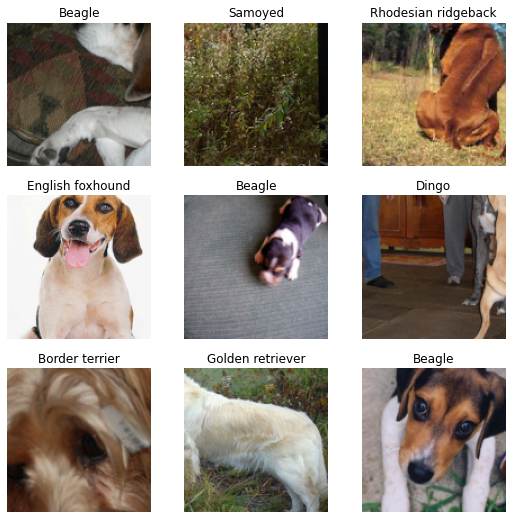

In [17]:
#frist create the data for the models
data = create_data()

model with blur and lr finder

storing logs in 20210117_124103_blur40epochs_0.008lr.csv


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,top_2_accuracy,time
0,1.955728,1.872247,0.337999,0.658692,0.536269,01:24
1,1.847813,1.911986,0.354798,0.694070,0.567574,01:24
2,1.782563,2.212868,0.339272,0.657674,0.519725,01:24
3,1.749276,1.614193,0.439298,0.740901,0.641639,01:24
4,1.669556,1.787279,0.400865,0.719522,0.602698,01:23
5,1.596986,1.554121,0.455587,0.764317,0.660473,01:23
6,1.498149,2.421657,0.337745,0.662255,0.537287,01:23
7,1.397689,1.429383,0.554340,0.812166,0.719267,01:24
8,1.310259,1.707433,0.414864,0.694833,0.585645,01:24
9,1.206364,1.179372,0.588190,0.856197,0.773988,01:24


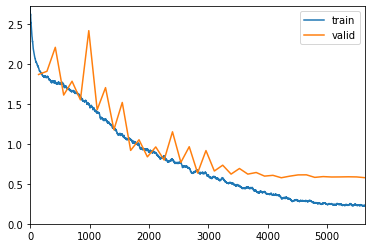

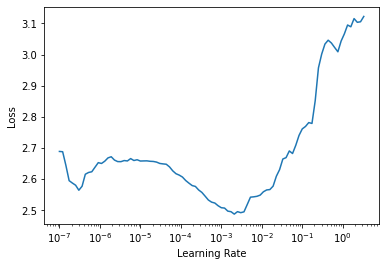

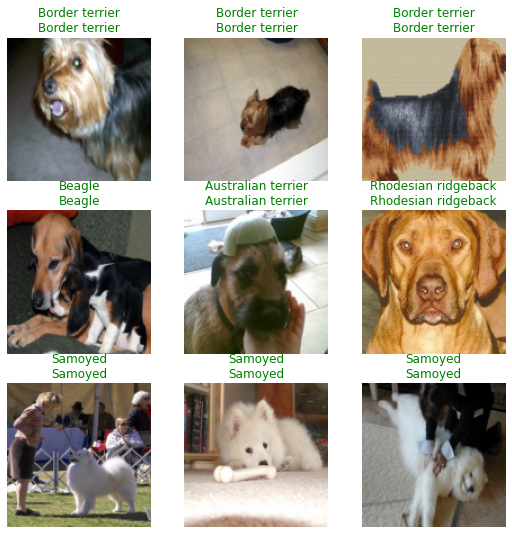

In [20]:
learner,epochs,lr = get_learner(data, blur=True, epochs=40)
get_LR(learner)
train(learner, epochs, lr)

model with blur, no lr finder

storing logs in 20210117_133803_blur40epochs_0.008lr.csv


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,top_2_accuracy,time
0,1.989459,1.904698,0.334945,0.659964,0.539323,01:24
1,1.847719,1.779897,0.372868,0.706796,0.577501,01:23
2,1.847486,2.623337,0.279460,0.607534,0.469076,01:23
3,1.806448,1.642499,0.433698,0.738865,0.621023,01:23
4,1.732408,2.363615,0.261135,0.615169,0.451769,01:23
5,1.636676,1.441309,0.503945,0.815729,0.715195,01:24
6,1.498113,1.898386,0.374905,0.691525,0.571138,01:25
7,1.417567,1.204714,0.588190,0.859506,0.770425,01:23
8,1.336694,1.463895,0.503181,0.802240,0.691525,01:23
9,1.229502,1.012245,0.648511,0.891575,0.817765,01:24


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


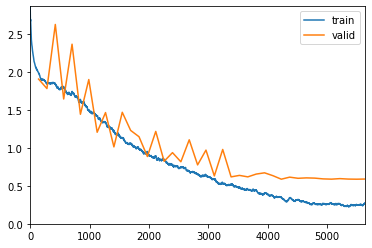

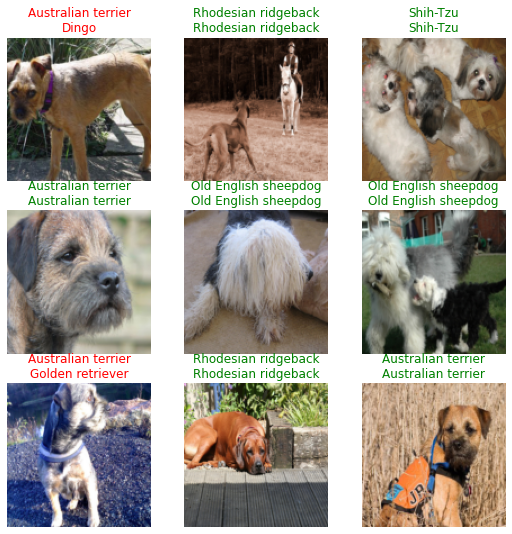

In [21]:
learner,epochs,lr = get_learner(data, blur=True, epochs=40)
#get_LR(learner)
train(learner, epochs, lr)

run it longer


In [ ]:
learner,epochs,lr = get_learner(data, blur=True, epochs=80)
get_LR(learner)
train(learner, epochs, lr)